<a href="https://colab.research.google.com/github/Ash100/MDS/blob/main/SSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...


In [ ]:
!conda install -y -c conda-forge ambertools

In [13]:
!pip install -q pytraj

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import pytraj as pt

# Example paths
dcd_path = "/content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_prod1-20_whole.dcd"
pdb_path = "/content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_equil.pdb"

# Load trajectory
traj = pt.load(dcd_path, top=pdb_path)

In [66]:
%%writefile cpptraj_sasa.in
parm /content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_equil.pdb

# Load full system trajectory (protein + ligand + solvent)
trajin /content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_prod1-20_whole.dcd
strip @H=
surf complex_sasa out complex_sasa.dat
run
clear all

# Protein only (residues 1 to 487)
parm /content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_equil.pdb
trajin /content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_prod1-20_whole.dcd
strip !:1-403
strip @H=
trajout protein.dcd
trajout protein.pdb pdb
run
clear all

parm protein.pdb
trajin protein.dcd
surf protein_sasa out protein_sasa.dat
run
clear all

# Ligand only (residue 404)
parm /content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_equil.pdb
trajin /content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_prod1-20_whole.dcd
strip !:404
strip @H=
trajout ligand.dcd
trajout ligand.pdb pdb
run
clear all

parm ligand.pdb
trajin ligand.dcd
surf ligand_sasa out ligand_sasa.dat
run


Overwriting cpptraj_sasa.in


In [67]:
!cpptraj -i cpptraj_sasa.in



CPPTRAJ: Trajectory Analysis. V6.24.0 (AmberTools)
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 07/01/25 16:56:53
| Available memory: 1.062 GB

INPUT: Reading input from 'cpptraj_sasa.in'
  [parm /content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_equil.pdb]
	Reading '/content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_equil.pdb' as PDB File
	Reading bond info from CONECT records.
	Not reading bond info from LINK records.
	Determining bond info from distances.
  [trajin /content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_prod1-20_whole.dcd]
	Reading '/content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_prod1-20_whole.dcd' as Charmm DCD
	Symmetric shape matrix detected.
  [strip @H=]
    STRIP: Stripping atoms in mask [@H*]
  [surf complex_sasa out complex_sasa.dat]
    SURF: Calculating LCPO surface area for all solute atoms.
	Solute will be all molecules not marked as solvent with size > 1 atom.
	van der Waals offset is 1.4 Ang.
	Cutoff for determining whether atoms 

In [68]:
import numpy as np

sasa_protein = np.loadtxt("protein_sasa.dat", usecols=1)
sasa_ligand = np.loadtxt("ligand_sasa.dat", usecols=1)
sasa_complex = np.loadtxt("complex_sasa.dat", usecols=1)

frames_protein = np.arange(len(sasa_protein))
frames_ligand = np.arange(len(sasa_ligand))
frames_complex = np.arange(len(sasa_complex))

print("Lengths:")
print(f"Protein SASA: {len(sasa_protein)}")
print(f"Ligand SASA: {len(sasa_ligand)}")
print(f"Complex SASA: {len(sasa_complex)}")


Lengths:
Protein SASA: 1000
Ligand SASA: 1000
Complex SASA: 1000


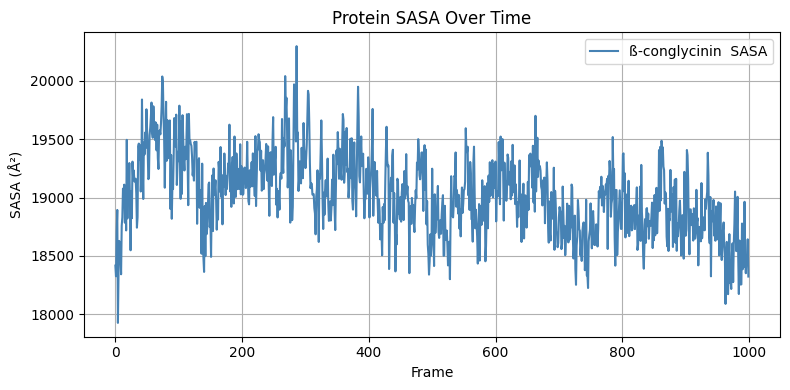

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(frames_protein, sasa_protein, color='steelblue', label='ß-conglycinin  SASA')
plt.xlabel("Frame")
plt.ylabel("SASA (Å²)")
plt.title("Protein SASA Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("/content/3aup_sasa_plot.png", dpi=600)
plt.show()


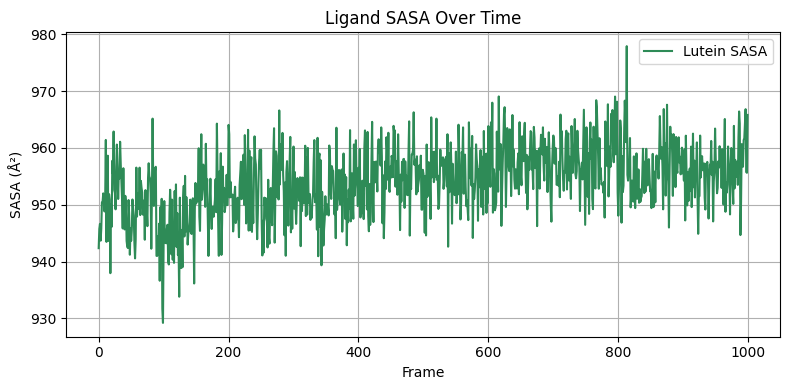

In [76]:
plt.figure(figsize=(8, 4))
plt.plot(frames_ligand, sasa_ligand, color='seagreen', label='Lutein SASA')
plt.xlabel("Frame")
plt.ylabel("SASA (Å²)")
plt.title("Ligand SASA Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("/content/3aup_ligand_sasa_plot.png", dpi=600)
plt.show()


In [71]:
min_len = min(len(sasa_protein), len(sasa_ligand), len(sasa_complex))
bsa = sasa_protein[:min_len] + sasa_ligand[:min_len] - sasa_complex[:min_len]


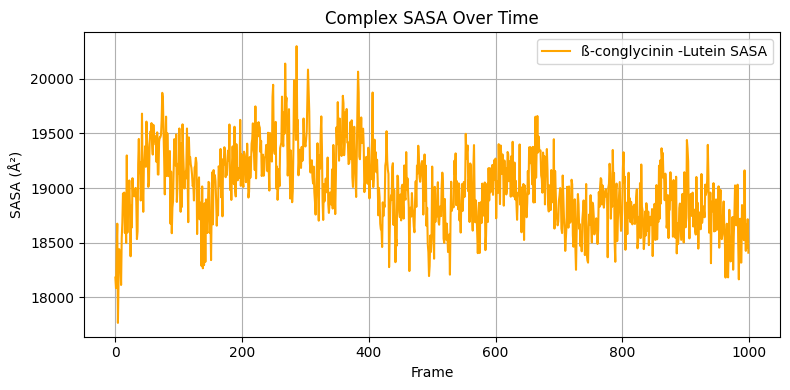

In [77]:
plt.figure(figsize=(8, 4))
plt.plot(frames_complex, sasa_complex, color='orange', label='ß-conglycinin -Lutein SASA')
plt.xlabel("Frame")
plt.ylabel("SASA (Å²)")
plt.title("Complex SASA Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("/content/3aup_complex_sasa_plot.png", dpi=600)
plt.show()


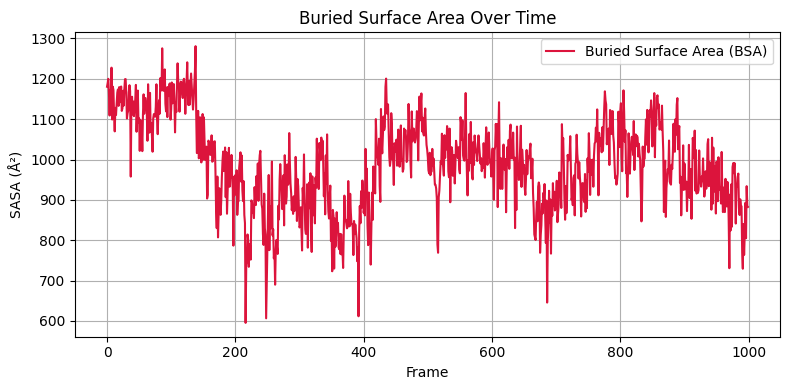

In [78]:
bsa = sasa_protein[:min_len] + sasa_ligand[:min_len] - sasa_complex[:min_len]

plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(bsa)), bsa, color='crimson', label='Buried Surface Area (BSA)')
plt.xlabel("Frame")
plt.ylabel("SASA (Å²)")
plt.title("Buried Surface Area Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("/content/3aup_bsa_plot_600dpi.png", dpi=600)
plt.show()


In [74]:
import numpy as np

# Load SASA data
sasa_protein = np.loadtxt("protein_sasa.dat", usecols=1)
sasa_ligand  = np.loadtxt("ligand_sasa.dat", usecols=1)
sasa_complex = np.loadtxt("complex_sasa.dat", usecols=1)

# Crop to shortest common length
min_len = min(len(sasa_protein), len(sasa_ligand), len(sasa_complex))
sasa_protein = sasa_protein[:min_len]
sasa_ligand  = sasa_ligand[:min_len]
sasa_complex = sasa_complex[:min_len]

# Calculate BSA
bsa = sasa_protein + sasa_ligand - sasa_complex

# Print key statistics
print("========= SASA Summary =========")
print(f"Frames analyzed: {min_len}")
print(f"Protein SASA   (mean ± std): {np.mean(sasa_protein):.2f} ± {np.std(sasa_protein):.2f} Å²")
print(f"Ligand SASA    (mean ± std): {np.mean(sasa_ligand):.2f} ± {np.std(sasa_ligand):.2f} Å²")
print(f"Complex SASA   (mean ± std): {np.mean(sasa_complex):.2f} ± {np.std(sasa_complex):.2f} Å²")
print(f"BSA            (mean ± std): {np.mean(bsa):.2f} ± {np.std(bsa):.2f} Å²")
print("================================")


========= SASA Summary =========
Frames analyzed: 1000
Protein SASA   (mean ± std): 19023.86 ± 340.15 Å²
Ligand SASA    (mean ± std): 954.10 ± 6.10 Å²
Complex SASA   (mean ± std): 18990.95 ± 351.27 Å²
BSA            (mean ± std): 987.01 ± 111.20 Å²


In [16]:
cat > cpptraj_sasa.in << 'EOF'
parm /content/drive/MyDrive/your_folder/complex.pdb
trajin /content/drive/MyDrive/your_folder/trajectory.dcd
surf complex_sasa !@H=
surf protein_sasa :1-9999 & !@H=
surf ligand_sasa :LIG & !@H=
EOF


SyntaxError: invalid syntax (ipython-input-16-1316672443.py, line 1)

In [15]:
import pytraj as pt
import numpy as np
# Create cpptraj object
cpp = pt.Cpptraj()
cpp.load_topology(pdb_path)
cpp.load_traj(dcd_path)

# Setup surf commands
cpp.commands = """
surf sasa_complex !@H=
surf sasa_protein :1-9999 & !@H=
surf sasa_ligand :LIG & !@H=
run
"""

# Run the analysis
results = cpp.run()


AttributeError: module 'pytraj' has no attribute 'Cpptraj'

In [11]:
# Run cpptraj with embedded commands
results = pt._cpptraj(commands, return_data=True)

# Access SASA data
sasa_complex = np.array(results['complex_sasa'])
sasa_protein = np.array(results['protein_sasa'])
sasa_ligand  = np.array(results['ligand_sasa'])

# Compute BSA
bsa = sasa_protein + sasa_ligand - sasa_complex

AttributeError: module 'pytraj' has no attribute '_cpptraj'

In [7]:
import pytraj as pt
import numpy as np

# Load your trajectory
pdb_path = "/content/drive/MyDrive/Dr_Zeeshan/d105/105_lig_equil.pdb"
dcd_path = "/content/drive/MyDrive/Dr_Zeeshan/d105/105_lig_prod1-20_wd_water.dcd"

traj = pt.load(dcd_path, top=pdb_path)

# ✅ SASA for the full complex (excluding hydrogens)
sasa_complex = pt.calc_sasa(traj, mask='!@H=', probe_radius=1.4)

# ✅ SASA for protein only
sasa_protein = pt.calc_sasa(traj, mask=':1-9999 & !@H=', probe_radius=1.4)  # adjust residue range

# ✅ SASA for ligand only
sasa_ligand = pt.calc_sasa(traj, mask=':LIG & !@H=', probe_radius=1.4)  # replace LIG with your ligand name

# ✅ Compute Buried Surface Area (BSA)
sasa_protein = np.array(sasa_protein)
sasa_ligand = np.array(sasa_ligand)
sasa_complex = np.array(sasa_complex)

bsa = sasa_protein + sasa_ligand - sasa_complex


AttributeError: module 'pytraj' has no attribute 'calc_sasa'